# **Exercise 06: scatter matrix**

Prepare the project:

In [1]:
%pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


Import allowed modules:

In [3]:
import sqlite3

import pandas as pd

Import allowed entities:

In [4]:
from pandas import DataFrame
from sqlite3 import Connection
from pandas.plotting import scatter_matrix

Create a dictionary for connection to the database:

In [5]:
conn_params: dict = {"db_file": "checking_logs.sqlite", "db_file_path": "../../data/", }

Make a connection to the [database](https://drive.google.com/open?id=1zQ8AR2Ry3ajzB3UZO1Sfk3xtDJlzQF2M):

In [6]:
conn: Connection = sqlite3.connect(conn_params["db_file_path"] + conn_params["db_file"], )

Check a connection:

In [7]:
conn.cursor().execute("SELECT 123;", );

Create a queries:

In [8]:
sql_q_chker: str = """
                   SELECT
                       *
                   FROM
                       checker;
                   """
sql_q_pageviews: str = """
                       SELECT
                           *
                       FROM
                           pageviews;
                       """
sql_q_deadlines: str = """
                       SELECT
                           *
                       FROM
                           deadlines;
                       """

Run a queries:

In [9]:
chker: DataFrame = pd.io.sql.read_sql(
    sql_q_chker,
    conn,
    parse_dates=["timestamp", ],
)
pageviews: DataFrame = pd.io.sql.read_sql(
    sql_q_pageviews,
    conn,
    parse_dates=["datetime", ],
)
deadlines: DataFrame = pd.io.sql.read_sql(
    sql_q_deadlines,
    conn,
    parse_dates=["deadlines", ],
)

Check them:

In [10]:
chker.head()

,index,status,success,timestamp,numTrials,labname,uid
0,0,checking,0,2020-04-16 21:12:50.740474,5,None,admin_1
1,1,ready,0,2020-04-16 21:12:54.708365,5,code_rvw,admin_1
2,2,checking,0,2020-04-16 21:46:47.769088,7,None,admin_1
3,3,ready,0,2020-04-16 21:46:48.121217,7,lab02,admin_1
4,4,checking,0,2020-04-16 21:53:01.862637,6,code_rvw,admin_1


In [11]:
pageviews.head()

,index,uid,datetime
0,0,admin_1,2020-04-17 12:01:08.463179
1,1,admin_1,2020-04-17 12:01:23.743946
2,2,admin_3,2020-04-17 12:17:39.287778
3,3,admin_3,2020-04-17 12:17:40.001768
4,4,admin_1,2020-04-17 12:27:30.646665


In [12]:
deadlines.head()

,index,labs,deadlines
0,0,laba04,2020-04-26 23:59:59
1,1,laba04s,2020-04-26 23:59:59
2,2,laba05,2020-05-03 23:59:59
3,4,laba06,2020-05-24 23:59:59
4,5,laba06s,2020-05-24 23:59:59


## Create a *Pandas* dataframe where each user of the test group has: the average difference, number of pageviews, number of commits.

## Do not take `project1` into account for calculations of the average difference and the number of commits.

## Take the number of commits from the `checker` table:

In [13]:
df: DataFrame = (
    chker[
        (chker["status"] == "ready") &
        (chker["numTrials"] == 1) &
        (chker["labname"].isin([
            "laba04",
            "laba04s",
            "laba05",
            "laba06",
            "laba06s",
            "project1",
        ], )) &
        (chker["uid"].str.startswith("user_", ))
    ]
    .groupby(["uid", "labname", ], )["timestamp"].min().reset_index(name="first_commit", )
    .merge(
        pageviews.groupby("uid", )["datetime"].min().reset_index(name="first_view", ),
        on="uid",
        how="left",
    )
    .query("first_view.notna()", )
    .merge(
        deadlines,
        left_on="labname",
        right_on="labs",
    )
    .query('labname != "project1"', )
    .assign(diff_hours=lambda x: (x["deadlines"].astype("int64", ) // 10**9 - x["first_commit"].astype("int64", ) // 10**9) / 3600)
    .groupby("uid", )
    .agg(avg_diff=("diff_hours", "mean", ), )
    .reset_index()
    .merge(
        pageviews[pageviews["uid"].str.startswith("user_", )]
        .groupby("uid", ).size().rename("pageviews", ),
        on="uid",
        how="left",
    )
    .merge(
        chker[(chker["uid"].str.startswith("user_", )) & (chker["labname"] != "project1")]
        .groupby("uid", ).size().rename("commits", ),
        on="uid",
        how="left",
    )
)

## The `figsize=` is still the same, you can choose whatever `fontsize=` you like as well as the color palette.

## The size of the dots should be `200`.

## The width of the lines of the diagonal graphs should be `3`:

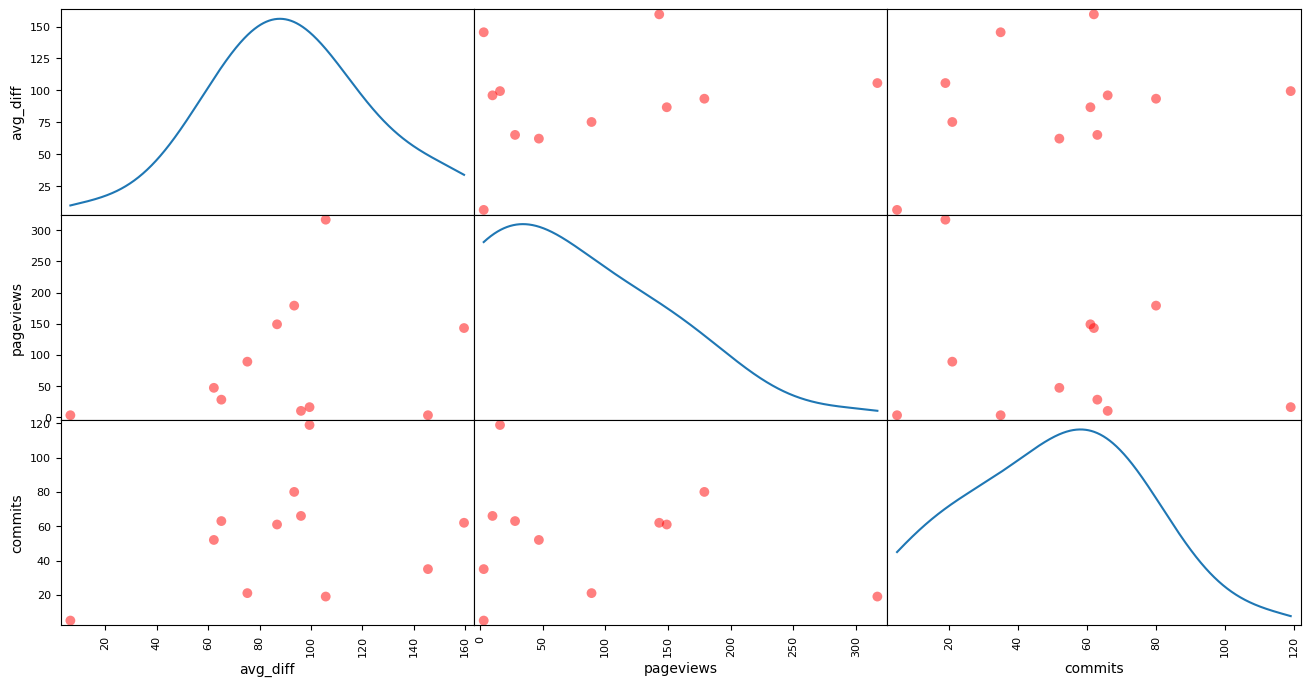

In [14]:
scatter_matrix(
    df[[
        "avg_diff",
        "pageviews",
        "commits",
    ]],
    s=200,
    color="red",
    diagonal="kde",
    figsize=(16, 8, ),
    hist_kwds={"linewidth": 3, },
);

## At the end of *Jupyter Notebook*, create a markdown cell and insert the questions:

* `"Can we say that if a user has a low number of pageviews then they likely have a low number of commits?"`

Answer: no.

* `"Can we say that if a user has a low number of pageviews then they likely have a small average difference between the first commit and the lab deadline?"`

Answer: no.

* `"Can we say that there are many users with a low number of commits and a few with a high number of commits?"`

Answer: yes.

* `"Can we say that there are many users with a small average difference and a few with a large average difference?"`

Answer: no.

Close the connection to the database:

In [15]:
conn.close()